# Lead Scoring Case Study

### Logistic Regression

Steps involved are:
1. Read and Understand the data
2. Cleaning Data
3. Preparing Data
4. Checking Correlations
5. Splitting Data into Training and Test Sets
6. Feature Standardization
7. Model building
8. Feature Selection Using RFE
9. Metrics beyond simply accuracy
10. Finding Optimal Cutoff Point
11. Making predictions on the test set
12. Assigning Lead Scores to the records as per the original data set

## Step 1: Read and Understand the data

In [1]:
# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set pandas display format so it will not use scientific notaion
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set numpy display format to not display floats in scientific notation
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Removing unnecessary warnings in jupyter notebook
import warnings
warnings.simplefilter(action='ignore')

# Importing the below library and configuring to display all columns in a dataframe
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
# Reading the given dataset into a Dataframe
df = pd.read_csv('Leads.csv', encoding='ISO-8859-1');
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [3]:
# checking the data
df.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0        0.000   
1  Organic Search           No          No          0        5.000   
2  Direct Traffic           No          No          1        2.000   
3  Direct Traffic           No          No          0        1.000   
4          Google           No          No          1        2.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   
1                          674                 2.500             Email Opened   
2                         1532                 2.000             Email Opened   
3                          305                 1.000              Unreachable   
4                         1428                 1.000        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [4]:
# Checking the percentage of missing values
df.isna().mean().round(4) * 100

Prospect ID                                      0.000
Lead Number                                      0.000
Lead Origin                                      0.000
Lead Source                                      0.390
Do Not Email                                     0.000
Do Not Call                                      0.000
Converted                                        0.000
TotalVisits                                      1.480
Total Time Spent on Website                      0.000
Page Views Per Visit                             1.480
Last Activity                                    1.110
Country                                         26.630
Specialization                                  15.560
How did you hear about X Education              23.890
What is your current occupation                 29.110
What matters most to you in choosing a course   29.320
Search                                           0.000
Magazine                                         0.000
Newspaper 

In [5]:
df.shape

(9240, 37)

### Keeping a copy of the original data frame to append a lead score finally

In [6]:
df_orig = df.copy()

## Step 2: Cleaning Data

It can be seen that a lot of column have the value 'Select' in them. These look like the default value in the web form which got entered in the form when the user did not select any option. We can default these values to 'NaN' and then do a data cleaning.

In [7]:
# Replacing "Select" value with NaN value
df = df.replace('Select', np.NaN)

In [8]:
# Writing a function to remove columns and rows with all Null values
# Also dropping columns with more than 25% NaN values
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

def clean_data_frame(df):    
    #Drop columns with all NaN Values
    df = df.dropna(axis=1, how='all')
    #Drop rows with all NaN Values
    df = df.dropna(axis=0, how='all') 
    for col in df.columns:
        # Removing column with > 25% Nan values
        if df[col].isnull().mean() > 0.25:
            df = df.drop(col, axis=1)
        elif col in numeric_columns:
            # Removing numeric columns with zero deviation
            if df[col].std() == 0:
                print(col, ' has no deviation')
                df = df.drop(col, axis = 1)
    return df

In [9]:
df = clean_data_frame(df)
df.shape

(9240, 24)

In [10]:
# Checking the percentage of missing values
df.isna().mean().round(4) * 100

Prospect ID                                0.000
Lead Number                                0.000
Lead Origin                                0.000
Lead Source                                0.390
Do Not Email                               0.000
Do Not Call                                0.000
Converted                                  0.000
TotalVisits                                1.480
Total Time Spent on Website                0.000
Page Views Per Visit                       1.480
Last Activity                              1.110
Search                                     0.000
Magazine                                   0.000
Newspaper Article                          0.000
X Education Forums                         0.000
Newspaper                                  0.000
Digital Advertisement                      0.000
Through Recommendations                    0.000
Receive More Updates About Our Courses     0.000
Update me on Supply Chain Content          0.000
Get updates on DM Co

### Treating continuous variables (TotalVisits, Page Views Per Visit) 

In [11]:
# number of null values
df[['TotalVisits', 'Page Views Per Visit']].isnull().sum()

TotalVisits             137
Page Views Per Visit    137
dtype: int64

In [12]:
# imputing the null values with its median
df['TotalVisits'] = df['TotalVisits'].fillna(df['TotalVisits'].median())
df['Page Views Per Visit'] = df['Page Views Per Visit'].fillna(df['Page Views Per Visit'].median())

In [13]:
# checking the percentage of missing values
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [14]:
missing_data(df).head(24)

Total  Percent
Last Activity                               103    1.115
Lead Source                                  36    0.390
Last Notable Activity                         0    0.000
A free copy of Mastering The Interview        0    0.000
Lead Number                                   0    0.000
Lead Origin                                   0    0.000
Do Not Email                                  0    0.000
Do Not Call                                   0    0.000
Converted                                     0    0.000
TotalVisits                                   0    0.000
Total Time Spent on Website                   0    0.000
Page Views Per Visit                          0    0.000
Search                                        0    0.000
Magazine                                      0    0.000
Newspaper Article                             0    0.000
X Education Forums                            0    0.000
Newspaper                                     0    0.000
Digital Advertisement                         0    0.000
Through Recommendations                       0    0.000
Receive More Updates About Our Courses        0    0.000
Update me on Supply Chain Content             0    0.000
Get updates on DM Content                     0    0.000
I agree to pay the amount through cheque      0    0.000
Prospect ID                                   0    0.000

#### The cleaned dataset looks good, we have negligible Nan values in 2 columns (< 1.5%). Let us now check for outliers

### Checking outliers

In [15]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
count     9240.000   9240.000     9240.000                     9240.000   
mean    617188.436      0.385        3.439                      487.698   
std      23405.996      0.487        4.819                      548.021   
min     579533.000      0.000        0.000                        0.000   
25%     596484.500      0.000        1.000                       12.000   
50%     615479.000      0.000        3.000                      248.000   
75%     637387.250      1.000        5.000                      936.000   
90%     650506.100      1.000        7.000                     1380.000   
95%     655404.050      1.000       10.000                     1562.000   
99%     659592.980      1.000       17.000                     1840.610   
max     660737.000      1.000      251.000                     2272.000   

       Page Views Per Visit  
count              9240.000  
mean                  2.357  
std                   2.146  
min                   0.000  
25%                   1.000  
50%                   2.000  
75%                   3.000  
90%                   5.000  
95%                   6.000  
99%                   9.000  
max                  55.000

In [16]:
# Univariate Analysis for numerical variables to check for outliers, discrepancies in data

def create_box_plots_from_dataframe(df, columns, save_file_name, size=(20,12)):
    # defaulting figureSize and selecting number of rows as modulo of 5
    fig, ax=plt.subplots(nrows=len(columns)//5,ncols=5,figsize=size,squeeze=False)
    
    # Create a box plot for each column in the dataframe
    for col in columns:
        sns.boxplot(data=df[col], ax=ax[columns.index(col)//5][columns.index(col)%5], orient='v')
        
        # Setting column name as title for each sub plot
        ax[columns.index(col)//5][columns.index(col)%5].title.set_text(col)
    
    # To better differenciate the individual subplots while displaying
    fig.tight_layout()
    
    # Save the box plot image
    plt.savefig('./plots/'+save_file_name+'.png', bbox_inches='tight')

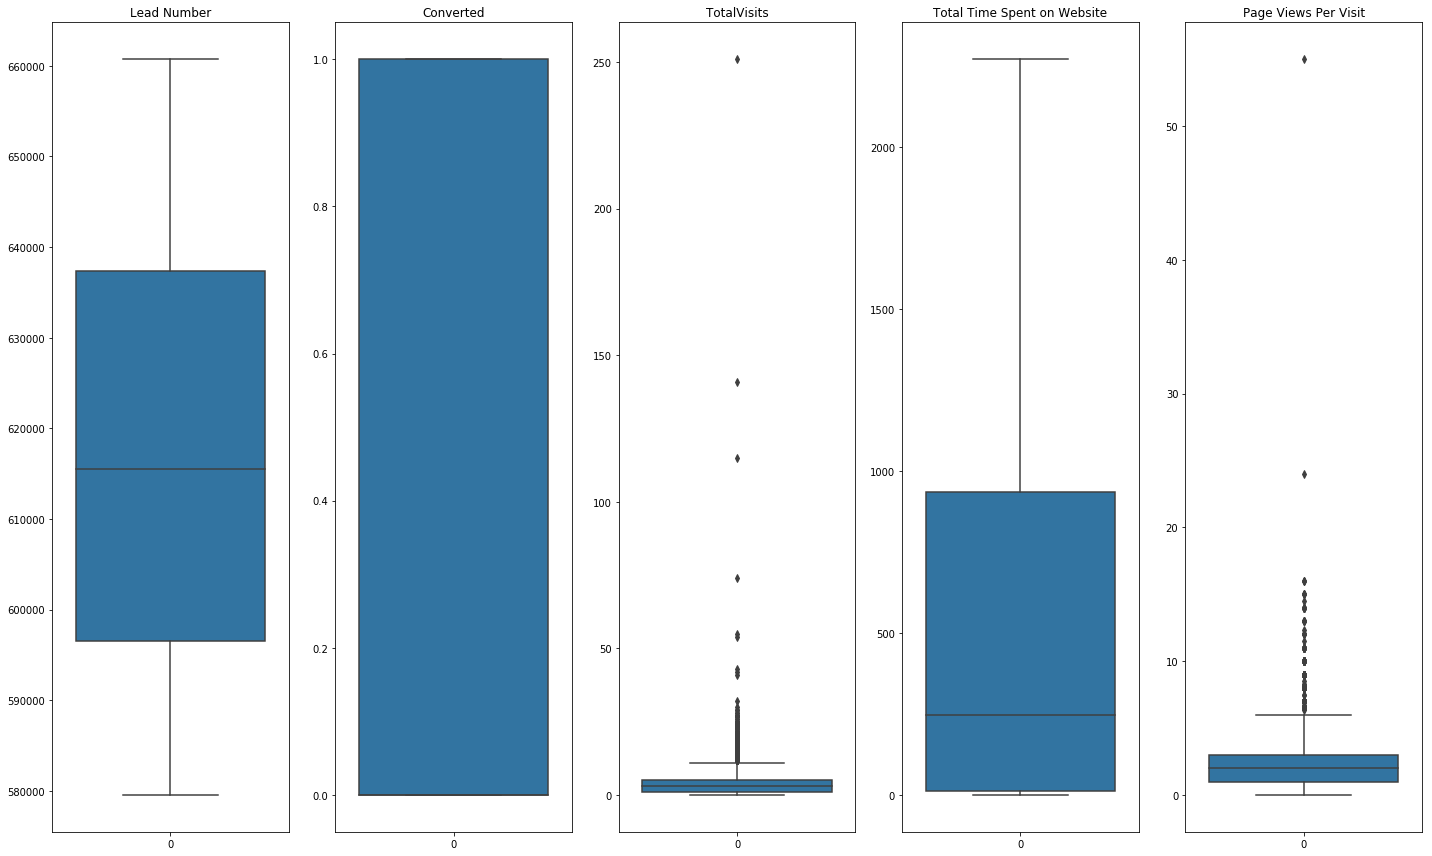

In [17]:
create_box_plots_from_dataframe(df, df.select_dtypes(include=[np.number]).columns.tolist(), "univariate_analysis")


#### From the distribution shown above, we do observe outliers in the columns Total Visits and Page Views per Visit. The outliers however dont appear to be incorrect data and since the number of outliers in these columns is a lot, we can decide to not treat them as it would result in a lot of lost data. So we can proceed with creating dummy variables now.

In [18]:
df.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0        0.000   
1  Organic Search           No          No          0        5.000   
2  Direct Traffic           No          No          1        2.000   
3  Direct Traffic           No          No          0        1.000   
4          Google           No          No          1        2.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   
1                          674                 2.500             Email Opened   
2                         1532                 2.000             Email Opened   
3                          305                 1.000              Unreachable   
4                         1428                 1.000        Converted to Lead   

  Search Magazine Newspaper Article X Education Forums Newspaper  \
0     No       No                No                 No        No   
1     No       No                No                 No        No   
2     No       No                No                 No        No   
3     No       No                No                 No        No   
4     No       No                No                 No        No   

  Digital Advertisement Through Recommendations  \
0                    No                      No   
1                    No                      No   
2                    No                      No   
3                    No                      No   
4                    No                      No   

  Receive More Updates About Our Courses Update me on Supply Chain Content  \
0                                     No                                No   
1                                     No                                No   
2                                     No                                No   
3                                     No                                No   
4                                     No                                No   

  Get updates on DM Content I agree to pay the amount through cheque  \
0                        No                                       No   
1                        No                                       No   
2                        No                                       No   
3                        No                                       No   
4                        No                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified

## Step 3: Preparing Data

### Analysing the data columns to add dummies, remove cols etc

In [19]:
# List of yes no cols
yes_no_cols = ['Do Not Email','Do Not Call','Search','Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque','A free copy of Mastering The Interview']

# Columns to create dummies from
vars_for_dummies = ['Lead Origin','Lead Source','Do Not Email','Do Not Call','Last Activity','Last Notable Activity']

# Only No values in this column, so it can be dropped as it has zero variance
only_no_cols = ['Magazine']
df = df.drop('Magazine', axis=1)

In [20]:
# Defining the map function to update Yes/No to 1/0
def binary_map(x):
    return x.map({'Yes': 1, 'No': 0})

# Applying the function to the housing list
df[yes_no_cols] = df[yes_no_cols].apply(binary_map)

In [21]:
### Creating dummy variables
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummies = pd.get_dummies(df[vars_for_dummies], drop_first=True)

# Adding the results to the master dataframe
df = pd.concat([df, dummies], axis=1)

# Dropping prospect ID as it is just a record id
df = df.drop('Prospect ID', axis=1)

df.shape

(9240, 79)

In [22]:
# Dropping the original columns
df = df.drop(vars_for_dummies, axis=1)
df.shape

(9240, 71)

In [23]:
df.head()

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0       660737          0        0.000                            0   
1       660728          0        5.000                          674   
2       660727          1        2.000                         1532   
3       660719          0        1.000                          305   
4       660681          1        2.000                         1428   

   Page Views Per Visit  Search  Newspaper Article  X Education Forums  \
0                 0.000       0                  0                   0   
1                 2.500       0                  0                   0   
2                 2.000       0                  0                   0   
3                 1.000       0                  0                   0   
4                 1.000       0                  0                   0   

   Newspaper  Digital Advertisement  Through Recommendations  \
0          0                      0                        0   
1          0                      0                        0   
2          0                      0                        0   
3          0                      0                        0   
4          0                      0                        0   

   Receive More Updates About Our Courses  Update me on Supply Chain Content  \
0                                       0                                  0   
1                                       0                                  0   
2                                       0                                  0   
3                                       0                                  0   
4                                       0                                  0   

   Get updates on DM Content  I agree to pay the amount through cheque  \
0                          0                                         0   
1                          0                                         0   
2                          0                                         0   
3                          0                                         0   
4                          0                                         0   

   A free copy of Mastering The Interview  \
0                                       0   
1                                       0   
2                                       1   
3                                       0   
4                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     0                   0   
3                           1                     0                   0   
4                           0                     0                   1   

   Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
0                      0                   0                       1   
1                      0                   0                       0   
2                      0                   0                       0   
3                      0                   0  

### Checking the conversion rate

In [24]:
conversion = (sum(df['Converted'])/len(df['Converted'].index))*100
conversion

38.53896103896104

#### We have almost 39% conversion rate

In [25]:
df.shape

(9240, 71)

#### We have 72 variables after creating dummy variables for categorical columns

## Step 4: Checking Correlations

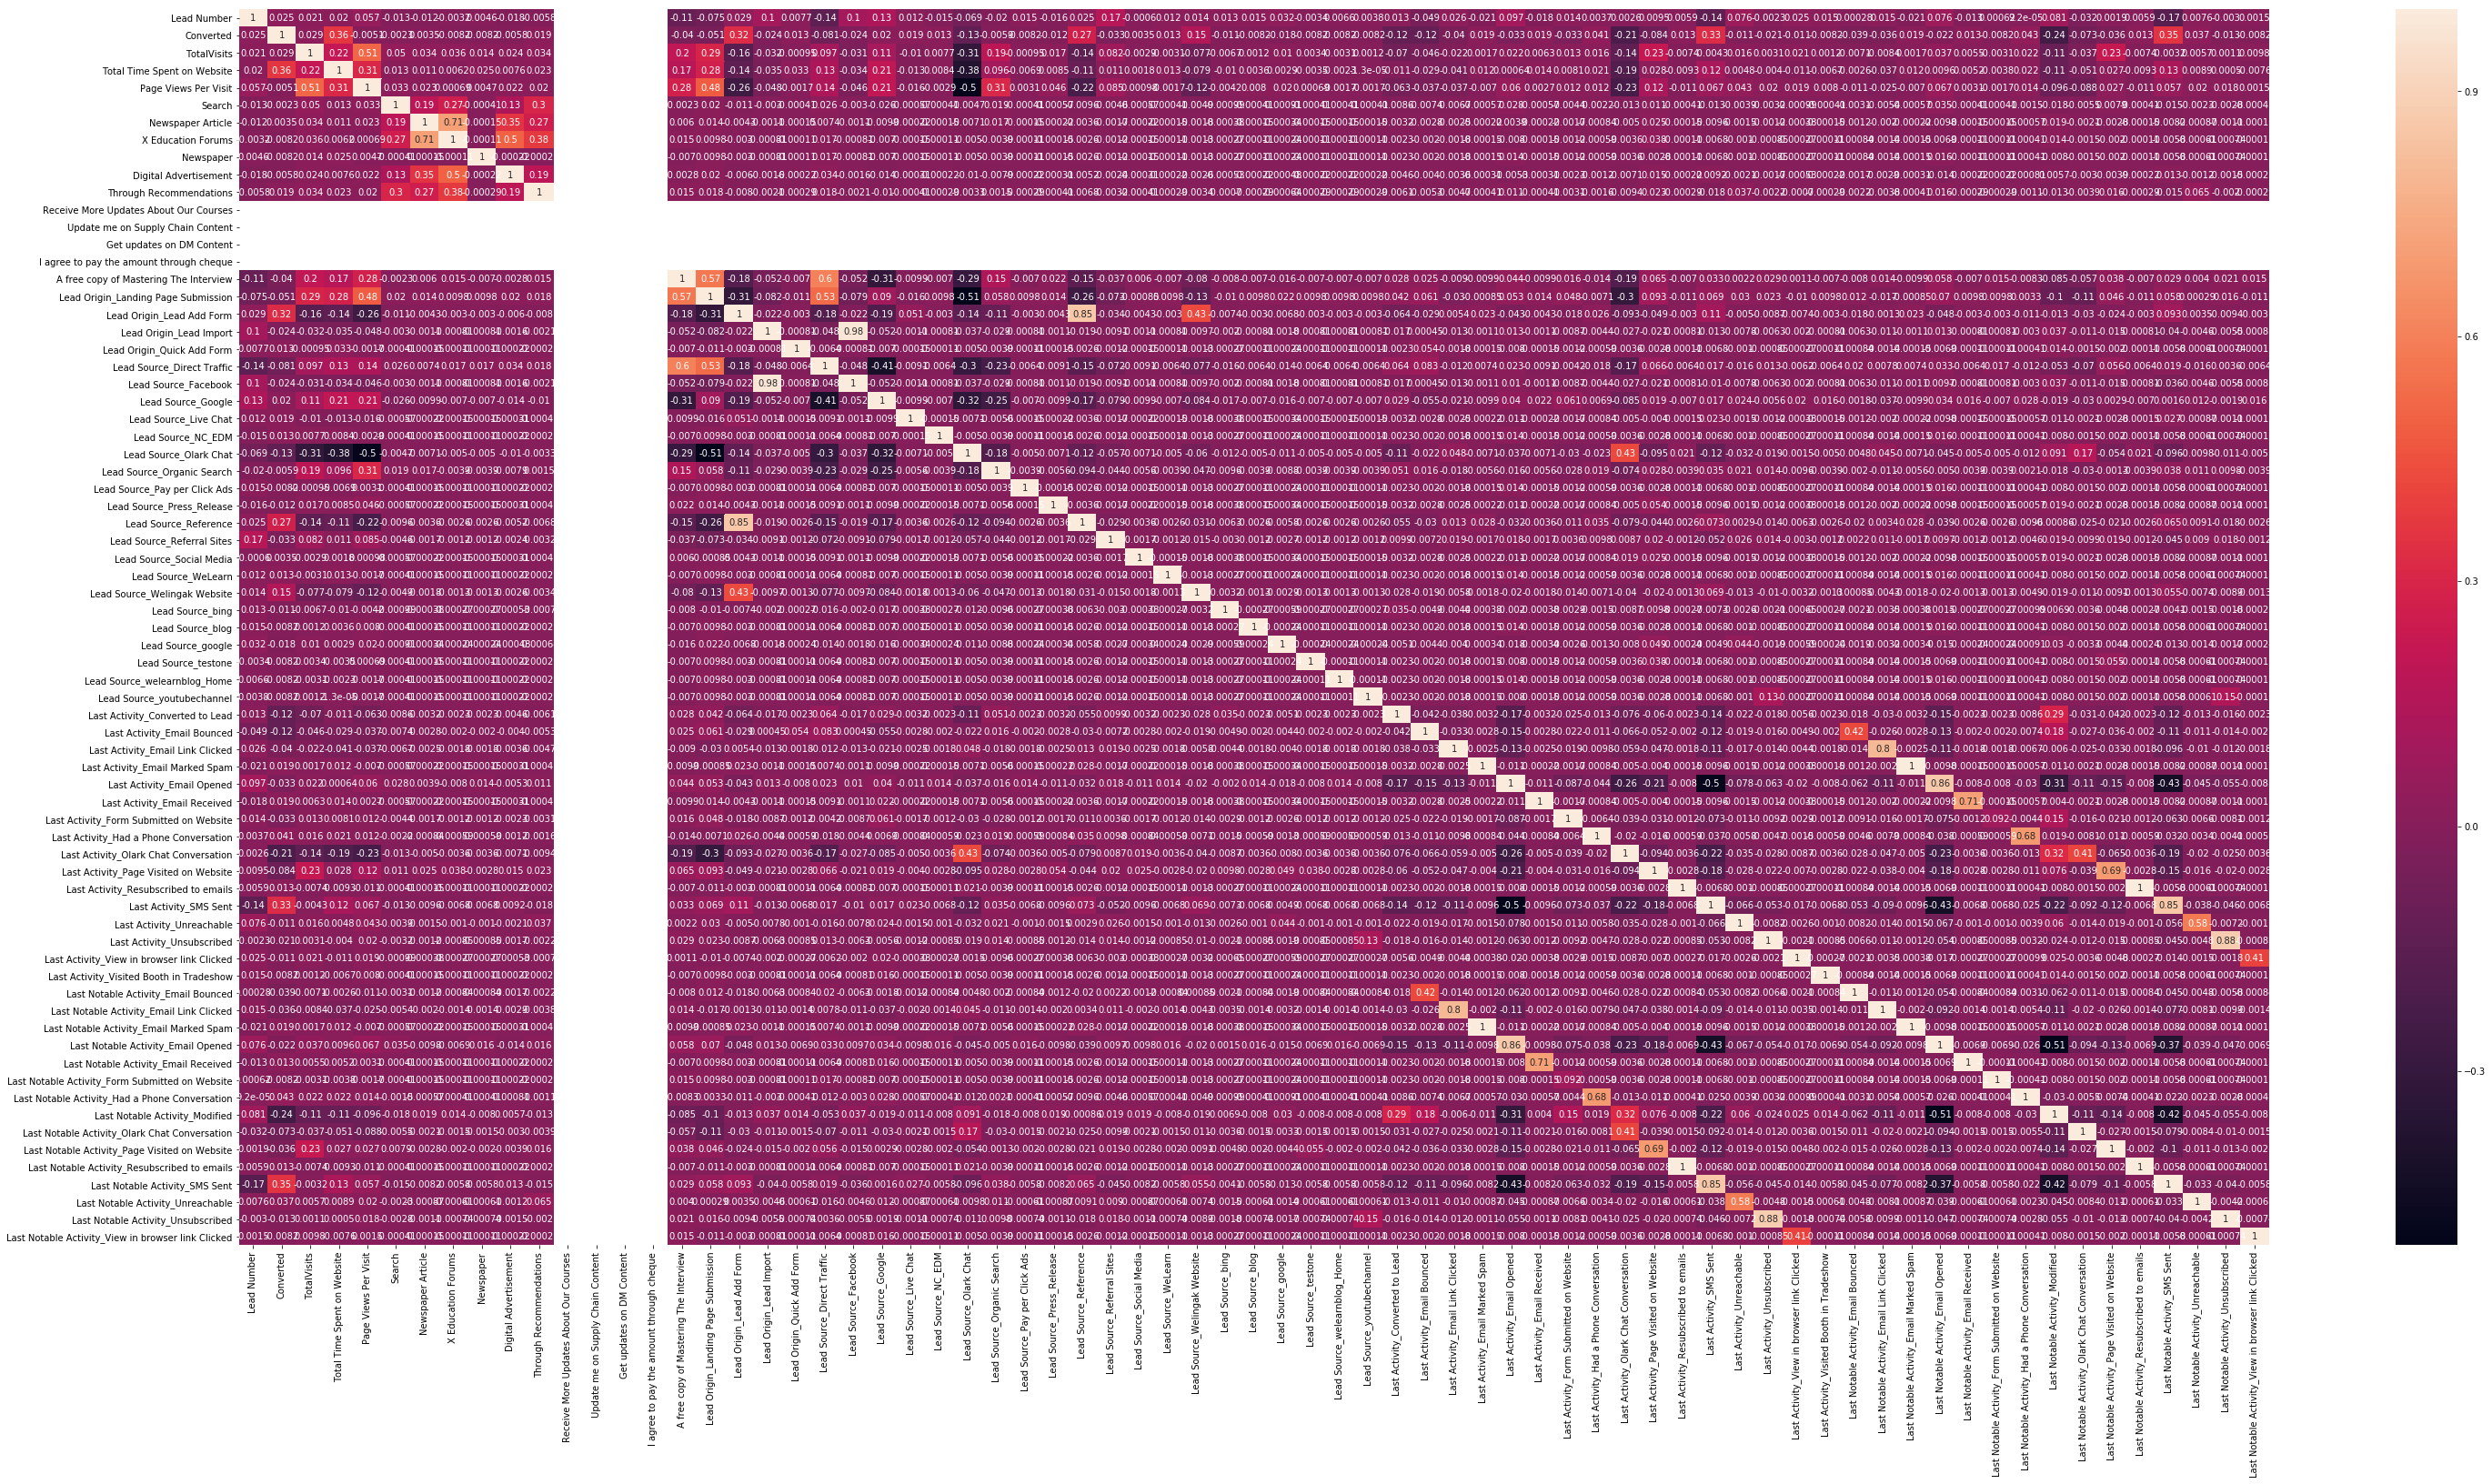

In [26]:
# Let's see the correlation matrix 
plt.figure(figsize = (50,25))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.savefig('./plots/heat_map_initial.png', bbox_inches='tight')
plt.show()

#### Dropping highly correlated dummy variables

#### Top correlations of df dataframe

In [27]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 20))

Top Absolute Correlations
Last Activity_Resubscribed to emails    Last Notable Activity_Resubscribed to emails     1.000
Last Activity_Email Marked Spam         Last Notable Activity_Email Marked Spam          1.000
Lead Origin_Lead Import                 Lead Source_Facebook                             0.982
Last Activity_Unsubscribed              Last Notable Activity_Unsubscribed               0.877
Last Activity_Email Opened              Last Notable Activity_Email Opened               0.863
Lead Origin_Lead Add Form               Lead Source_Reference                            0.853
Last Activity_SMS Sent                  Last Notable Activity_SMS Sent                   0.853
Last Activity_Email Link Clicked        Last Notable Activity_Email Link Clicked         0.801
Newspaper Article                       X Education Forums                               0.707
Last Activity_Email Received            Last Notable Activity_Email Received             0.707
Last Activity_Page Visit

In [28]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any((upper[column] > 0.80))]
to_drop

['Lead Source_Facebook',
 'Lead Source_Reference',
 'Last Notable Activity_Email Link Clicked',
 'Last Notable Activity_Email Marked Spam',
 'Last Notable Activity_Email Opened',
 'Last Notable Activity_Resubscribed to emails',
 'Last Notable Activity_SMS Sent',
 'Last Notable Activity_Unsubscribed']

In [29]:
df = df.drop(to_drop, 1)

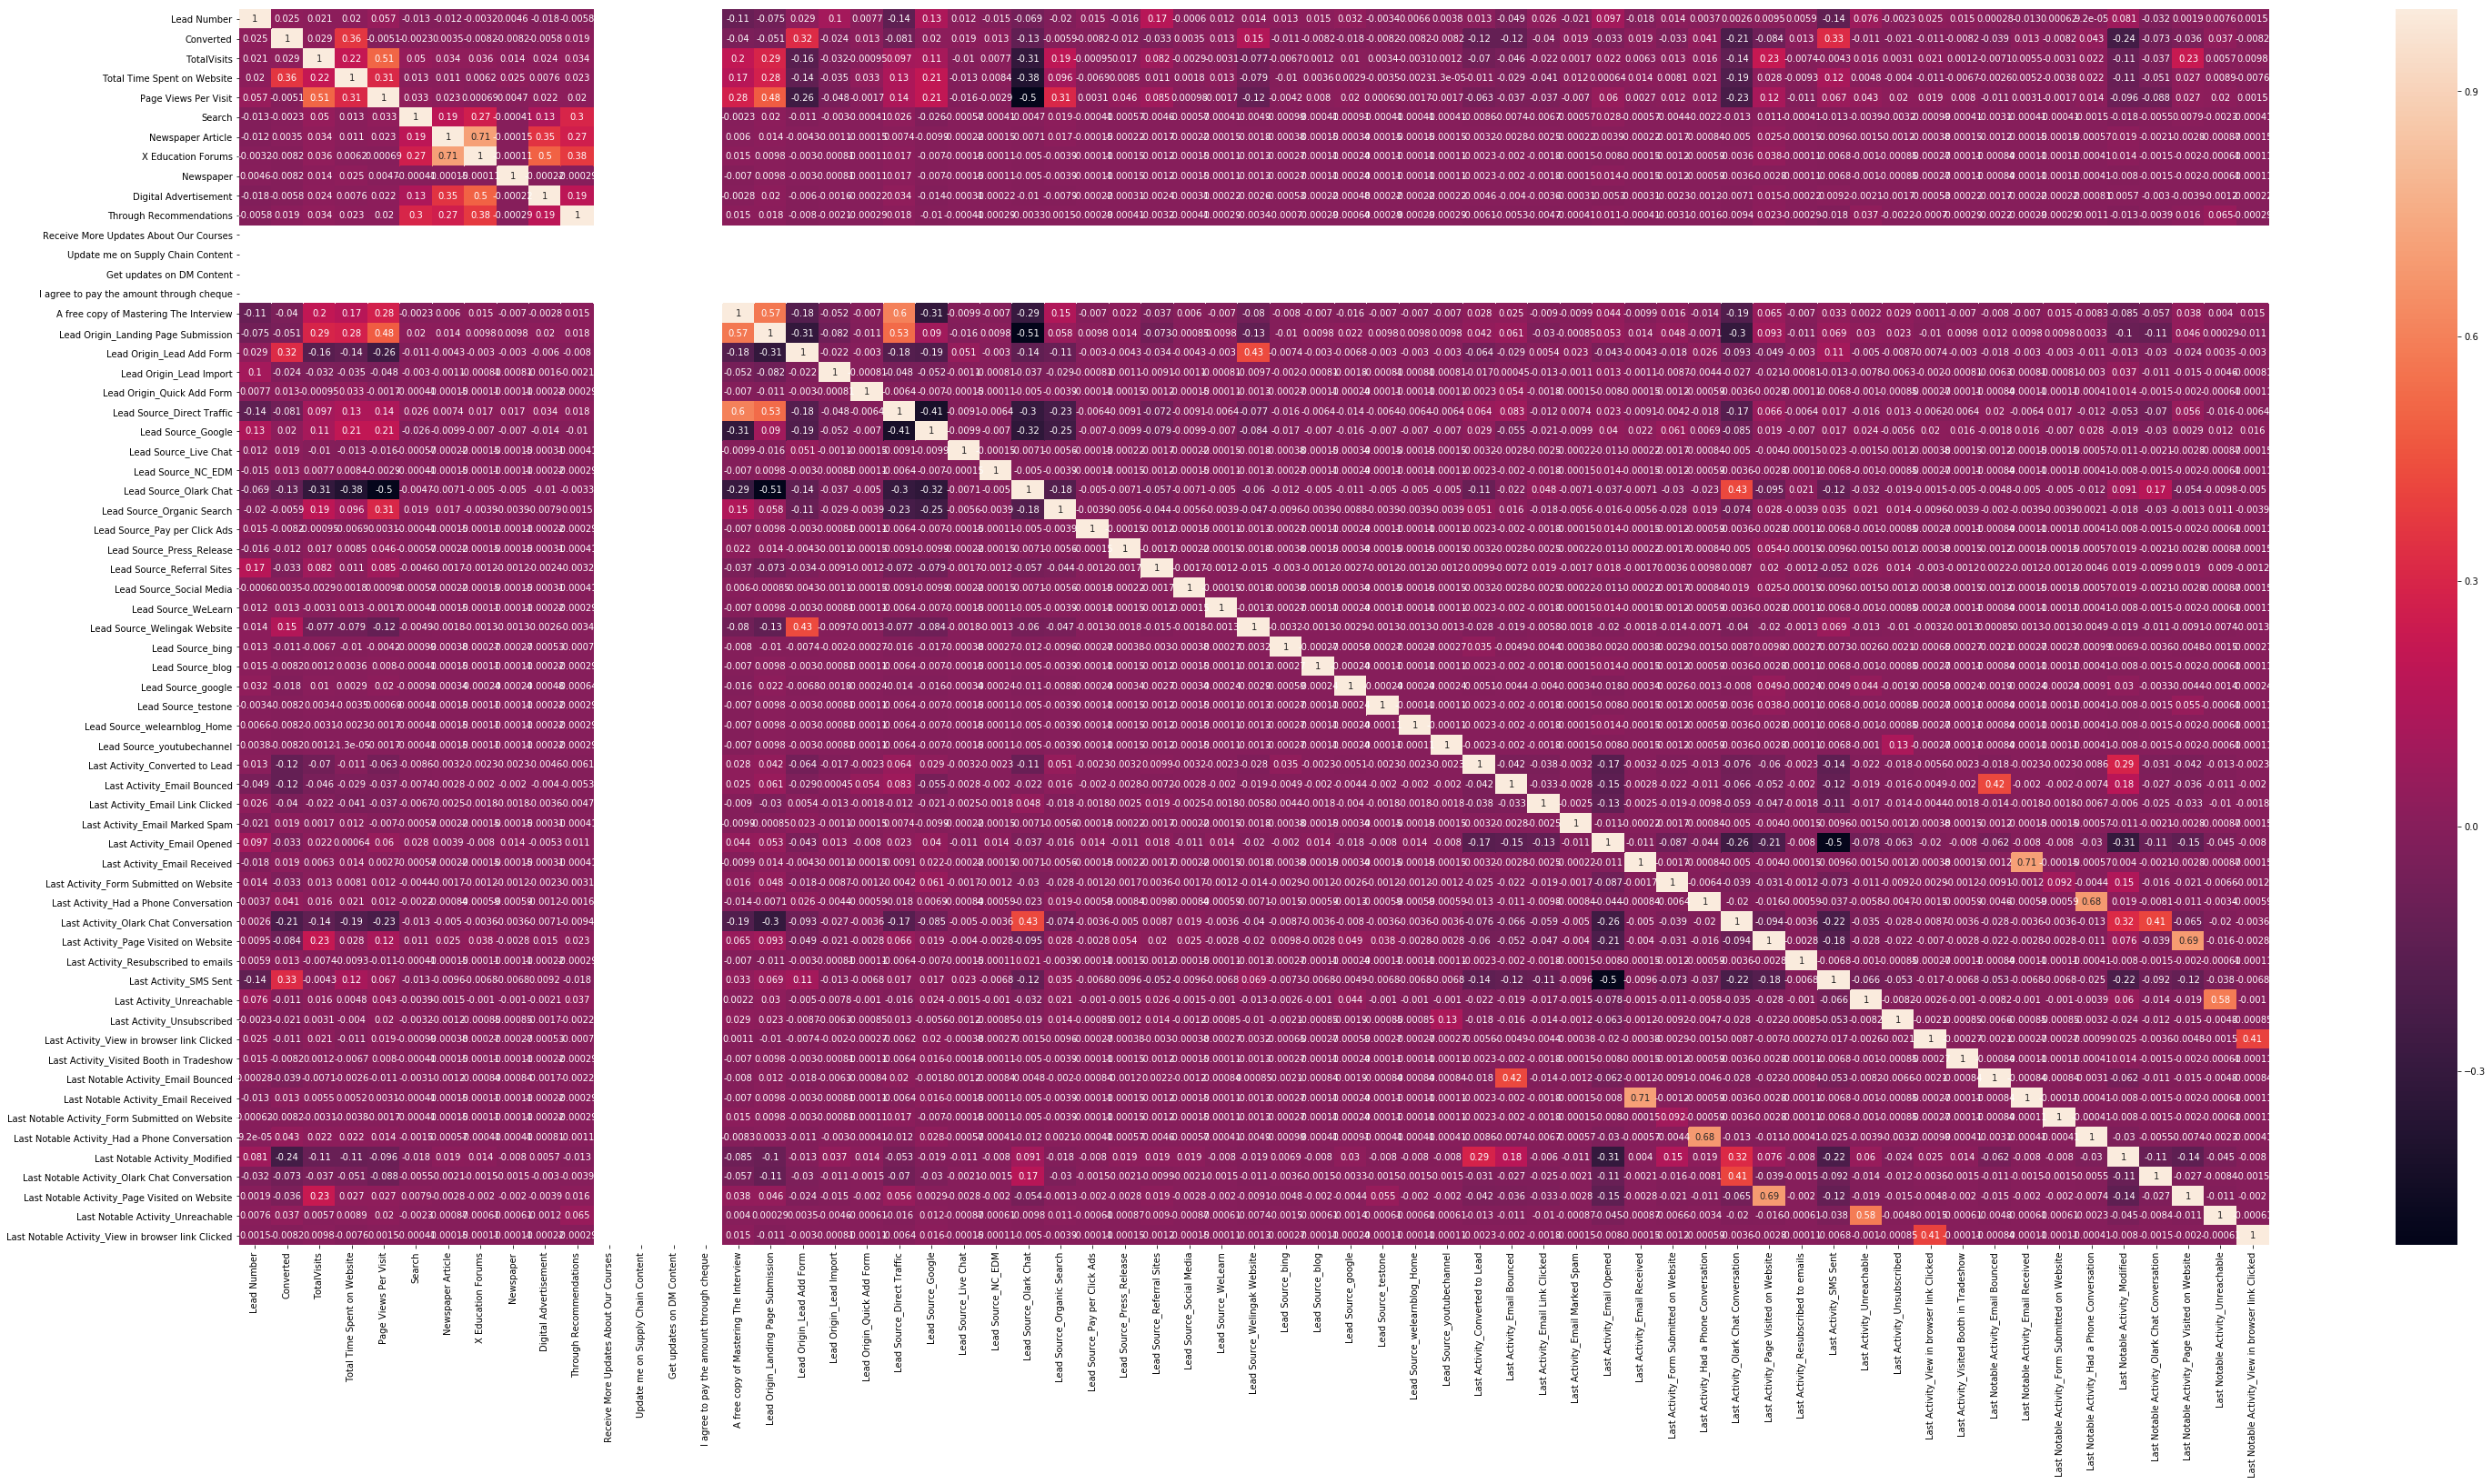

In [30]:
# Let's see the correlation matrix 
plt.figure(figsize = (50,25))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.savefig('./plots/heat_map_first_cut.png', bbox_inches='tight')
plt.show()

In [31]:
# Dropping the columns with no variance in them
df = df.drop(['Receive More Updates About Our Courses','Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque'], 1)

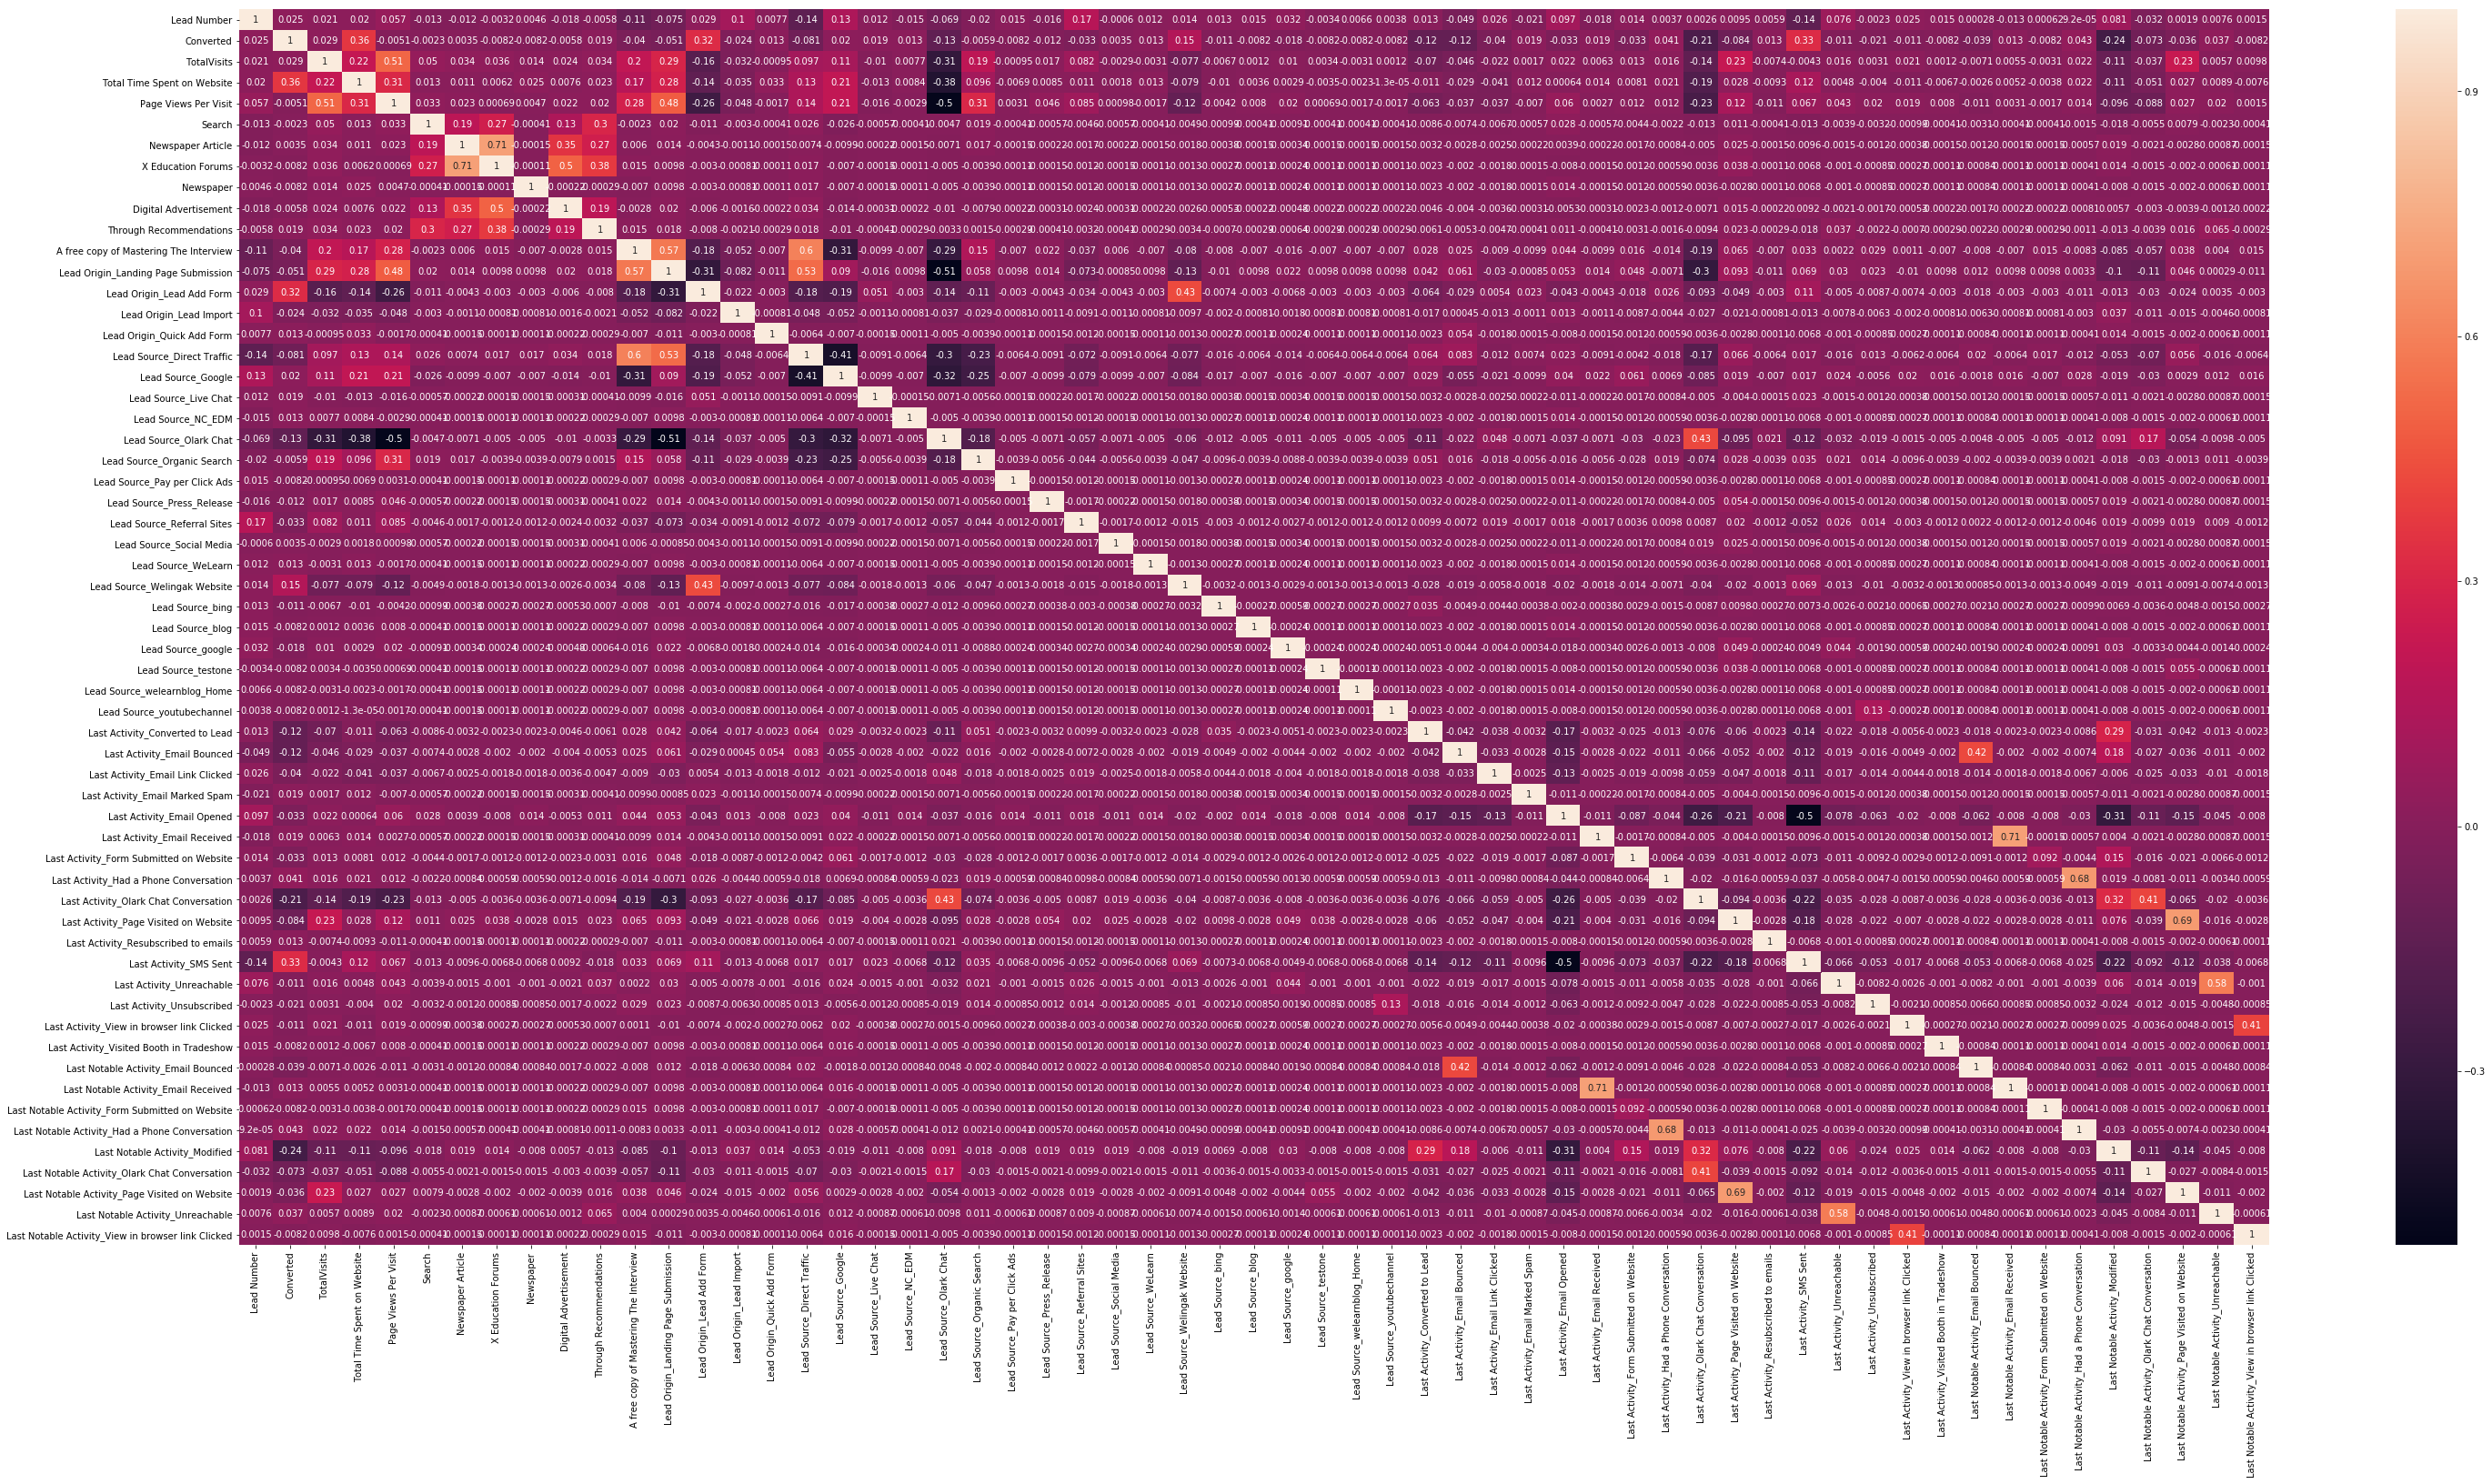

In [32]:
# Let's see the correlation matrix again
plt.figure(figsize = (50,25))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.savefig('./plots/heat_map_final.png', bbox_inches='tight')
plt.show()

In [33]:
df.shape

(9240, 59)

## Step 5: Splitting Data into Training and Test Sets

In [34]:
# importing library
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = df.drop(['Converted','Lead Number'],axis=1)

# Putting response variable to y
y = df['Converted']

In [35]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

## Step 6: Feature Standardization

In [36]:
# Normalising continuous features
# Creating a dataframe with just the continuous features
continuous_features = ['TotalVisits','Total Time Spent on Website']
X_train_1 = X_train[continuous_features]

In [37]:
# Normalizing the values for the continuous features
normalized_df=(X_train_1-X_train_1.mean())/X_train_1.std()

# Dropping the continuous features from the original dataframe
X_train = X_train.drop(continuous_features, 1)

# Concatenating the normalized values to the original data frame
X_train = pd.concat([X_train,normalized_df],axis=1)
X_train.head()

Page Views Per Visit  Search  Newspaper Article  X Education Forums  \
1871                 0.000       0                  0                   0   
6795                 1.330       0                  0                   0   
3516                 2.500       0                  0                   0   
8105                 5.000       0                  0                   0   
3934                 0.000       0                  0                   0   

      Newspaper  Digital Advertisement  Through Recommendations  \
1871          0                      0                        0   
6795          0                      0                        0   
3516          0                      0                        0   
8105          0                      0                        0   
3934          0                      0                        0   

      A free copy of Mastering The Interview  \
1871                                       0   
6795                                       1   
3516                                       0   
8105                                       0   
3934                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Google  Lead Source_Live Chat  \
1871                           0                   0                      0   
6795                           1                   0                      0   
3516                           0                   0                      0   
8105                           0                   1                      0   
3934                           0                   0                      0   

      Lead Source_NC_EDM  Lead Source_Olark Chat  Lead Source_Organic Search  \
1871                   0                       1                           0   
6795                   0                       0                           0   
3516                   0                       1                           0   
8105                   0                       0                           0   
3934                   0                       1                           0   

      Lead Source_Pay per Click Ads  Lead Source_Press_Release  \
1871                              0                          0   
6795                              0                          0   
3516                              0                          0   
8105                              0                          0   
3934                              0                          0   

      Lead Source_Referral Sites  Lead Source_Social Media  \
1871                           0                         0   
6795                           0                         0   
3516                           0                         0   
8105                           0                         0   
3934                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing  \
1871                    0                             0                 0   
6795                    0                             0                 0   
3516                    0                             0                 0   
8105             

## Step 7: Model building 

#### Running First Training Model

In [38]:
import statsmodels.api as sm

In [39]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6412
Model Family:                Binomial   Df Model:                           55
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2849.9
Date:                Sun, 25 Aug 2019   Deviance:                       5699.9
Time:                        10:40:32   Pearson chi2:                 6.66e+03
No. Iterations:                    22   Covariance Type:             nonrobust
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 -0.3608      1.487     -0.243      0.808      -3.276       2.555
Page Views Per Visit                                  -0.0565      0.024     -2.394      0.017      -0.103      -0.010
Search                                                 0.3559      0.739      0.482      0.630      -1.092       1.803
Newspaper Article                                     24.5610   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
X Education Forums                                   -26.7738   1.25e+05     -0.000      1.000   -2.46e+05    2.46e+05
Newspaper                                            -25.2305   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
Digital Advertisement                                -22.7502   5.58e+04     -0.000      1.000   -1.09e+05    1.09e+05
Through Recommendations                                2.2529      1.230      1.832      0.067      -0.157       4.663
A free copy of Mastering The Interview                 0.0069      0.101      0.069      0.945      -0.190       0.204
Lead Origin_Landing Page Submission                   -0.0980      0.102     -0.963      0.335      -0.297       0.101
Lead Origin_Lead Add Form                              3.0206      1.426      2.118      0.034       0.226       5.816
Lead Origin_Lead Import                               -0.8379      1.513     -0.554      0.580      -3.803       2.127
Lead Origin_Quick Add Form                            22.8523   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
Lead Source_Direct Traffic                            -1.1047      1.428     -0.773      0.439      -3.904       1.695
Lead Source_Google                                    -0.7260      1.425     -0.509      0.611      -3.520       2.068
Lead Source_Live Chat                                 20.4290   5.62e+04      0.000      1.000    -1.1e+05     1.1e+05
Lead Source_NC_EDM                                    22.6121   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
Lead Source_Olark Chat                                 0.0985      1.428      0.069      0.945      -2.701       2.898
Lead Source_Organic Search                            -0.9252      1.429     -0.647      0.517      -3.726       1.876
Lead Source_Pay per Click Ads                        -22.6708   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
Lead Source_Press_Release                            -22.9122   5.19e+04     -0.000      1.000   -1.02e+05    1.02e+05
Lead Source_Referral Sites                            -0.9289      1.455     -0.638      0.523      -3.780       1.923
Lead Source_Social Media                               1.4250      2.050      0.695      0.487      -2.593       5.443
Lead Source_WeLearn                                   22.2487   7.95

## Step 8:  Feature Selection Using RFE

In [40]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [41]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [42]:
rfe.support_

array([False, False, False, False,  True,  True,  True, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False,  True])

In [43]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Page Views Per Visit', False, 39),
 ('Search', False, 23),
 ('Newspaper Article', False, 19),
 ('X Education Forums', False, 26),
 ('Newspaper', True, 1),
 ('Digital Advertisement', True, 1),
 ('Through Recommendations', True, 1),
 ('A free copy of Mastering The Interview', False, 41),
 ('Lead Origin_Landing Page Submission', False, 34),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 11),
 ('Lead Origin_Quick Add Form', False, 24),
 ('Lead Source_Direct Traffic', False, 7),
 ('Lead Source_Google', False, 10),
 ('Lead Source_Live Chat', False, 37),
 ('Lead Source_NC_EDM', False, 21),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 8),
 ('Lead Source_Pay per Click Ads', False, 27),
 ('Lead Source_Press_Release', False, 6),
 ('Lead Source_Referral Sites', False, 9),
 ('Lead Source_Social Media', False, 2),
 ('Lead Source_WeLearn', False, 28),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 40),
 ('Lead 

In [44]:
col = X_train.columns[rfe.support_]
col

Index(['Newspaper', 'Digital Advertisement', 'Through Recommendations',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Last Activity_Email Bounced',
       'Last Activity_Email Received',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified', 'Last Notable Activity_Unreachable',
       'Total Time Spent on Website'],
      dtype='object')

In [45]:
X_train.columns[~rfe.support_]

Index(['Page Views Per Visit', 'Search', 'Newspaper Article',
       'X Education Forums', 'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form', 'Lead Source_Direct Traffic',
       'Lead Source_Google', 'Lead Source_Live Chat', 'Lead Source_NC_EDM',
       'Lead Source_Organic Search', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_WeLearn', 'Lead Source_bing',
       'Lead Source_blog', 'Lead Source_google', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Last Activity_Converted to Lead', 'Last Activity_Email Link Clicked',
       'Last Activity_Email Marked Spam', 'Last Activity_Email Opened',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Page Visited on Website',
       'Last Activity_Resubscribed to emails', '

#### Assessing the model with StatsModels

In [46]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2893.7
Date:                Sun, 25 Aug 2019   Deviance:                       5787.4
Time:                        10:40:34   Pearson chi2:                 6.64e+03
No. Iterations:                    20   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.0837      0.053    -20.381      0.000      -1.188      -0.979
Newspaper                                        -23.2232   2.92e+04     -0.001      0.999   -5.73e+04    5.73e+04
Digital Advertisement                            -21.7166   1.62e+04     -0.001      0.999   -3.17e+04    3.17e+04
Through Recommendations                            2.2108      1.231      1.796      0.073      -0.202       4.624
Lead Origin_Lead Add Form                          3.9941      0.184     21.751      0.000       3.634       4.354
Lead Source_Olark Chat                             1.1335      0.098     11.527      0.000       0.941       1.326
Lead Source_Welingak Website                       1.4642      0.742      1.974      0.048       0.010       2.918
Last Activity_Email Bounced                       -1.5552      0.293     -5.304      0.000      -2.130      -0.981
Last Activity_Email Received                      22.0118   2.06e+04      0.001      0.999   -4.04e+04    4.04e+04
Last Activity_Had a Phone Conversation             1.5212      0.816      1.863      0.062      -0.079       3.121
Last Activity_Olark Chat Conversation             -0.9436      0.165     -5.714      0.000      -1.267      -0.620
Last Activity_SMS Sent                             1.1732      0.070     16.652      0.000       1.035       1.311
Last Notable Activity_Had a Phone Conversation     1.8728      1.360      1.377      0.169      -0.793       4.539
Last Notable Activity_Modified                    -0.8920      0.077    -11.558      0.000      -1.043      -0.741
Last Notable Activity_Unreachable                  1.5501      0.497      3.116      0.002       0.575       2.525
Total Time Spent on Website                        1.1279      0.038     29.517      0.000       1.053       1.203
==================================================================================================================
"""

In [47]:
col1 = col.drop('Newspaper',1)

In [48]:
X_train_sm = sm.add_constant(X_train[col1])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2895.5
Date:                Sun, 25 Aug 2019   Deviance:                       5791.0
Time:                        10:40:34   Pearson chi2:                 6.64e+03
No. Iterations:                    20   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.0848      0.053    -20.407      0.000      -1.189      -0.981
Digital Advertisement                            -21.7171   1.62e+04     -0.001      0.999   -3.17e+04    3.17e+04
Through Recommendations                            2.2115      1.231      1.797      0.072      -0.201       4.624
Lead Origin_Lead Add Form                          3.9922      0.184     21.744      0.000       3.632       4.352
Lead Source_Olark Chat                             1.1319      0.098     11.513      0.000       0.939       1.325
Lead Source_Welingak Website                       1.4642      0.742      1.974      0.048       0.010       2.918
Last Activity_Email Bounced                       -1.5532      0.293     -5.299      0.000      -2.128      -0.979
Last Activity_Email Received                      22.0144   2.06e+04      0.001      0.999   -4.04e+04    4.04e+04
Last Activity_Had a Phone Conversation             1.5222      0.816      1.865      0.062      -0.078       3.122
Last Activity_Olark Chat Conversation             -0.9433      0.165     -5.713      0.000      -1.267      -0.620
Last Activity_SMS Sent                             1.1745      0.070     16.676      0.000       1.036       1.312
Last Notable Activity_Had a Phone Conversation     1.8720      1.360      1.377      0.169      -0.793       4.537
Last Notable Activity_Modified                    -0.8903      0.077    -11.540      0.000      -1.041      -0.739
Last Notable Activity_Unreachable                  1.5505      0.497      3.118      0.002       0.576       2.525
Total Time Spent on Website                        1.1255      0.038     29.488      0.000       1.051       1.200
==================================================================================================================
"""

In [49]:
col2 = col1.drop('Digital Advertisement',1)

In [50]:
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2897.5
Date:                Sun, 25 Aug 2019   Deviance:                       5795.0
Time:                        10:40:34   Pearson chi2:                 6.64e+03
No. Iterations:                    19   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.0846      0.053    -20.407      0.000      -1.189      -0.980
Through Recommendations                            1.4733      0.979      1.505      0.132      -0.446       3.393
Lead Origin_Lead Add Form                          3.9940      0.184     21.754      0.000       3.634       4.354
Lead Source_Olark Chat                             1.1332      0.098     11.529      0.000       0.941       1.326
Lead Source_Welingak Website                       1.4641      0.742      1.974      0.048       0.010       2.918
Last Activity_Email Bounced                       -1.5525      0.293     -5.296      0.000      -2.127      -0.978
Last Activity_Email Received                      21.0149   1.25e+04      0.002      0.999   -2.45e+04    2.45e+04
Last Activity_Had a Phone Conversation             1.5238      0.816      1.867      0.062      -0.076       3.124
Last Activity_Olark Chat Conversation             -0.9427      0.165     -5.710      0.000      -1.266      -0.619
Last Activity_SMS Sent                             1.1721      0.070     16.648      0.000       1.034       1.310
Last Notable Activity_Had a Phone Conversation     1.8703      1.360      1.375      0.169      -0.795       4.536
Last Notable Activity_Modified                    -0.8926      0.077    -11.573      0.000      -1.044      -0.741
Last Notable Activity_Unreachable                  1.5524      0.497      3.124      0.002       0.579       2.526
Total Time Spent on Website                        1.1258      0.038     29.508      0.000       1.051       1.201
==================================================================================================================
"""

In [51]:
col3 = col2.drop('Last Activity_Email Received',1)

In [52]:
X_train_sm = sm.add_constant(X_train[col3])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2899.4
Date:                Sun, 25 Aug 2019   Deviance:                       5798.7
Time:                        10:40:34   Pearson chi2:                 6.64e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -1.0827      0.053    -20.383      0.000      -1.187      -0.979
Through Recommendations                            1.4710      0.979      1.502      0.133      -0.448       3.390
Lead Origin_Lead Add Form                          3.9928      0.184     21.749      0.000       3.633       4.353
Lead Source_Olark Chat                             1.1325      0.098     11.524      0.000       0.940       1.325
Lead Source_Welingak Website                       1.4644      0.742      1.974      0.048       0.011       2.918
Last Activity_Email Bounced                       -1.5557      0.293     -5.307      0.000      -2.130      -0.981
Last Activity_Had a Phone Conversation             1.5202      0.816      1.862      0.063      -0.080       3.120
Last Activity_Olark Chat Conversation             -0.9449      0.165     -5.723      0.000      -1.268      -0.621
Last Activity_SMS Sent                             1.1700      0.070     16.622      0.000       1.032       1.308
Last Notable Activity_Had a Phone Conversation     1.8724      1.360      1.377      0.169      -0.793       4.538
Last Notable Activity_Modified                    -0.8911      0.077    -11.562      0.000      -1.042      -0.740
Last Notable Activity_Unreachable                  1.5509      0.497      3.121      0.002       0.577       2.525
Total Time Spent on Website                        1.1267      0.038     29.529      0.000       1.052       1.201
==================================================================================================================
"""

In [53]:
col4 = col3.drop('Last Notable Activity_Had a Phone Conversation',1)
X_train_sm = sm.add_constant(X_train[col4])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6456
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2900.4
Date:                Sun, 25 Aug 2019   Deviance:                       5800.9
Time:                        10:40:34   Pearson chi2:                 6.71e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.0803      0.053    -20.357      0.000      -1.184      -0.976
Through Recommendations                    1.4703      0.979      1.502      0.133      -0.449       3.389
Lead Origin_Lead Add Form                  3.9892      0.184     21.725      0.000       3.629       4.349
Lead Source_Olark Chat                     1.1305      0.098     11.506      0.000       0.938       1.323
Lead Source_Welingak Website               1.4671      0.742      1.978      0.048       0.013       2.921
Last Activity_Email Bounced               -1.5521      0.293     -5.297      0.000      -2.126      -0.978
Last Activity_Had a Phone Conversation     2.3921      0.617      3.874      0.000       1.182       3.602
Last Activity_Olark Chat Conversation     -0.9418      0.165     -5.705      0.000      -1.265      -0.618
Last Activity_SMS Sent                     1.1694      0.070     16.616      0.000       1.031       1.307
Last Notable Activity_Modified            -0.8976      0.077    -11.663      0.000      -1.048      -0.747
Last Notable Activity_Unreachable          1.5483      0.497      3.116      0.002       0.575       2.522
Total Time Spent on Website                1.1254      0.038     29.514      0.000       1.051       1.200
==========================================================================================================
"""

In [54]:
col5 = col4.drop('Through Recommendations',1)
X_train_sm = sm.add_constant(X_train[col5])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6457
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2901.6
Date:                Sun, 25 Aug 2019   Deviance:                       5803.2
Time:                        10:40:35   Pearson chi2:                 6.71e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.0770      0.053    -20.322      0.000      -1.181      -0.973
Lead Origin_Lead Add Form                  3.9871      0.184     21.716      0.000       3.627       4.347
Lead Source_Olark Chat                     1.1286      0.098     11.495      0.000       0.936       1.321
Lead Source_Welingak Website               1.4673      0.742      1.978      0.048       0.013       2.921
Last Activity_Email Bounced               -1.5547      0.293     -5.306      0.000      -2.129      -0.980
Last Activity_Had a Phone Conversation     2.3891      0.617      3.870      0.000       1.179       3.599
Last Activity_Olark Chat Conversation     -0.9435      0.165     -5.716      0.000      -1.267      -0.620
Last Activity_SMS Sent                     1.1666      0.070     16.585      0.000       1.029       1.304
Last Notable Activity_Modified            -0.8980      0.077    -11.670      0.000      -1.049      -0.747
Last Notable Activity_Unreachable          1.5581      0.494      3.153      0.002       0.590       2.527
Total Time Spent on Website                1.1254      0.038     29.530      0.000       1.051       1.200
==========================================================================================================
"""

In [55]:
col6 = col5.drop('Lead Source_Welingak Website',1)
X_train_sm = sm.add_constant(X_train[col6])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6458
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2904.5
Date:                Sun, 25 Aug 2019   Deviance:                       5809.0
Time:                        10:40:35   Pearson chi2:                 6.76e+03
No. Iterations:                     6   Covariance Type:             nonrobust
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.0769      0.053    -20.324      0.000      -1.181      -0.973
Lead Origin_Lead Add Form                  4.1392      0.178     23.303      0.000       3.791       4.487
Lead Source_Olark Chat                     1.1286      0.098     11.493      0.000       0.936       1.321
Last Activity_Email Bounced               -1.5524      0.292     -5.309      0.000      -2.126      -0.979
Last Activity_Had a Phone Conversation     2.3856      0.618      3.859      0.000       1.174       3.597
Last Activity_Olark Chat Conversation     -0.9434      0.165     -5.711      0.000      -1.267      -0.620
Last Activity_SMS Sent                     1.1682      0.070     16.615      0.000       1.030       1.306
Last Notable Activity_Modified            -0.9008      0.077    -11.710      0.000      -1.052      -0.750
Last Notable Activity_Unreachable          1.5570      0.494      3.149      0.002       0.588       2.526
Total Time Spent on Website                1.1254      0.038     29.520      0.000       1.051       1.200
==========================================================================================================
"""

#### p-value seems less than 0.05 for all variables (except the constant which is okay)

In [56]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

1871   0.280
6795   0.255
3516   0.326
8105   0.836
3934   0.136
4844   0.899
3297   0.130
8071   0.986
987    0.215
7423   0.910
dtype: float64

In [57]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.279986, 0.255321, 0.326012, 0.835844, 0.136424, 0.899137,
       0.130317, 0.985977, 0.214863, 0.909970])

#### Creating a dataframe with the actual converted flag and the predicted probabilities¶

In [58]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

Converted  Converted_prob  Prospect ID
0          0           0.280         1871
1          0           0.255         6795
2          0           0.326         3516
3          0           0.836         8105
4          0           0.136         3934

#### Creating new column 'predicted' with 1 if Converted_prob > 0.5 else 0

In [59]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Converted  Converted_prob  Prospect ID  predicted
0          0           0.280         1871          0
1          0           0.255         6795          0
2          0           0.326         3516          0
3          0           0.836         8105          1
4          0           0.136         3934          0

In [60]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3516  486]
 [ 806 1660]]


In [61]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.8002473716759431


## Our model now has an accuracy of 80% which is what the CEO wanted

#### Checking VIFs

In [62]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [63]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col6].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col6].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
8             Total Time Spent on Website 2.020
4   Last Activity_Olark Chat Conversation 1.570
3  Last Activity_Had a Phone Conversation 1.340
5                  Last Activity_SMS Sent 1.220
6          Last Notable Activity_Modified 1.100
2             Last Activity_Email Bounced 1.060
1                  Lead Source_Olark Chat 1.050
0               Lead Origin_Lead Add Form 1.000
7       Last Notable Activity_Unreachable 1.000

#### All variables have a good value of VIF (<=2). So we need not drop any more variables and we can proceed with making predictions using this model only

## Step 9: Metrics beyond simply accuracy

In [64]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [65]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6731549067315491

In [66]:
# Let us calculate specificity
TN / float(TN+FP)

0.8785607196401799

In [67]:
# Calculate false postive rate - predicting converted when customer does not have converted
print(FP/ float(TN+FP))

0.12143928035982009


In [68]:
# positive predictive value 
print (TP / float(TP+FP))

0.7735321528424977


In [69]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8135122628412772


### Plotting ROC curve for the train set

An ROC curve demonstrates several things:
- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [70]:
# Function to draw the ROC curve
# taken from the Logistic regression Telecom Churn code
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./plots/ROC.png', bbox_inches='tight')
    plt.show()

In [71]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_prob, drop_intermediate = False )


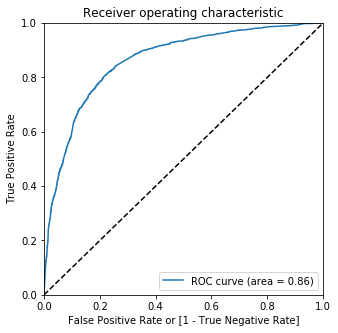

In [72]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

## We have an ROC curve area of 0.86 which is high and shows we have a good model

## Step 10: Finding Optimal Cutoff Point

#### Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [73]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Converted_prob  Prospect ID  predicted  0.0  0.1  0.2  0.3  0.4  \
0          0           0.280         1871          0    1    1    1    0    0   
1          0           0.255         6795          0    1    1    1    0    0   
2          0           0.326         3516          0    1    1    1    1    0   
3          0           0.836         8105          1    1    1    1    1    1   
4          0           0.136         3934          0    1    1    0    0    0   

   0.5  0.6  0.7  0.8  0.9  
0    0    0    0    0    0  
1    0    0    0    0    0  
2    0    0    0    0    0  
3    1    1    1    1    0  
4    0    0    0    0    0

In [74]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

       prob  accuracy  sensitivity  specificity
0.000 0.000     0.381        1.000        0.000
0.100 0.100     0.560        0.973        0.306
0.200 0.200     0.718        0.912        0.598
0.300 0.300     0.784        0.828        0.757
0.400 0.400     0.799        0.749        0.829
0.500 0.500     0.800        0.673        0.879
0.600 0.600     0.776        0.551        0.916
0.700 0.700     0.759        0.463        0.941
0.800 0.800     0.732        0.348        0.969
0.900 0.900     0.679        0.178        0.989


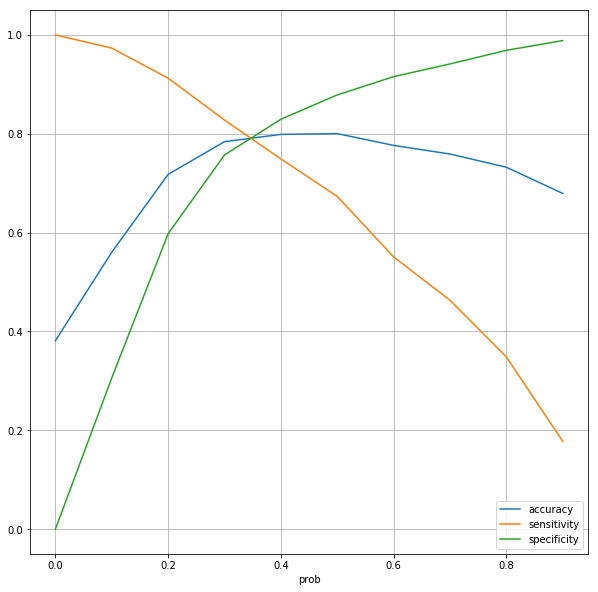

In [75]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'], grid={'color':'grey', 'linestyle':'--', 'linewidth':0.5}, figsize=(10,10))
plt.savefig('./plots/accu_sens_spec.png', bbox_inches='tight')
plt.show()

#### From the curve above, 0.36 is the optimum point to take it as a cutoff probability.

In [76]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.36 else 0)

y_train_pred_final.head()

Converted  Converted_prob  Prospect ID  predicted  0.0  0.1  0.2  0.3  0.4  \
0          0           0.280         1871          0    1    1    1    0    0   
1          0           0.255         6795          0    1    1    1    0    0   
2          0           0.326         3516          0    1    1    1    1    0   
3          0           0.836         8105          1    1    1    1    1    1   
4          0           0.136         3934          0    1    1    0    0    0   

   0.5  0.6  0.7  0.8  0.9  final_predicted  
0    0    0    0    0    0                0  
1    0    0    0    0    0                0  
2    0    0    0    0    0                0  
3    1    1    1    1    0                1  
4    0    0    0    0    0                0

In [77]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7948361162646876

In [78]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3220,  782],
       [ 545, 1921]], dtype=int64)

In [79]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [80]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7789943227899432

In [81]:
# Let us calculate specificity
TN / float(TN+FP)

0.8045977011494253

In [82]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.19540229885057472


In [83]:
# Positive predictive value 
print (TP / float(TP+FP))

0.710691823899371


In [84]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8552456839309429


### Precision and Recall

In [85]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

In [86]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7735321528424977

In [87]:
recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.6731549067315491

In [88]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

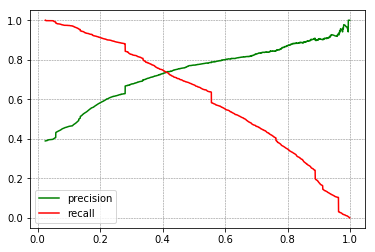

In [89]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.legend(['precision','recall'])
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.savefig('./plots/precisionVsRecall.png', bbox_inches='tight')
plt.show()

In [90]:
# Takin a prediction again with cutoff as 0.415
y_train_pred_final['final_pred'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.415 else 0)
# Checking the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_pred)

0.8004019789734076

#### Overall accuracy of 80.0% is acceptable. Lets plot a precision recall curve

### Assigning Lead Score

In [91]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

Converted  Converted_prob  Prospect ID  predicted  0.0  0.1  0.2  0.3  0.4  \
0          0           0.280         1871          0    1    1    1    0    0   
1          0           0.255         6795          0    1    1    1    0    0   
2          0           0.326         3516          0    1    1    1    1    0   
3          0           0.836         8105          1    1    1    1    1    1   
4          0           0.136         3934          0    1    1    0    0    0   

   0.5  0.6  0.7  0.8  0.9  final_predicted  final_pred  Lead_Score  
0    0    0    0    0    0                0           0          28  
1    0    0    0    0    0                0           0          26  
2    0    0    0    0    0                0           0          33  
3    1    1    1    1    0                1           1          84  
4    0    0    0    0    0                0           0          14

#### Now we get an accuracy of about 79%. Let us process with running the model on the test data

## Step 11: Making predictions on the test set

In [92]:
X_test.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  Search  \
4269        8.000                         1011                 8.000       0   
2376        0.000                            0                 0.000       0   
7766        5.000                           59                 5.000       0   
9199        0.000                            0                 0.000       0   
4359        0.000                            0                 0.000       0   

      Newspaper Article  X Education Forums  Newspaper  Digital Advertisement  \
4269                  0                   0          0                      0   
2376                  0                   0          0                      0   
7766                  0                   0          0                      0   
9199                  0                   0          0                      0   
4359                  0                   0          0                      0   

      Through Recommendations  A free copy of Mastering The Interview  \
4269                        0                                       0   
2376                        0                                       0   
7766                        0                                       0   
9199                        0                                       0   
4359                        0                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
4269                                    0                          0   
2376                                    0                          1   
7766                                    0                          0   
9199                                    0                          0   
4359                                    0                          1   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
4269                        0                           0   
2376                        0                           0   
7766                        0                           0   
9199                        0                           0   
4359                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Google  Lead Source_Live Chat  \
4269                           1                   0                      0   
2376                           0                   0                      0   
7766                           0                   1                      0   
9199                           0                   0                      0   
4359                           0                   0                      0   

      Lead Source_NC_EDM  Lead Source_Olark Chat  Lead Source_Organic Search  \
4269                   0                       0                           0   
2376                   0                       0                           0   
7766                   0                       0                           0   
9199                   0                       1                           0   
4359                   0                       0                           0   

      Lead Source_Pay per Click Ads  Lead Source_Press_Release  \
4269                              0                          0   
2376                              0                          0   
7766                              0                          0   
9199                              0                          0   
4359                              0                          0   

      Lead Source_Referral Sites  Lead Source_Social Media  \
4269                           0                         0   
2376                           0                         0   
7766                           0                         0   
9199                           0                         0   
4359                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing

In [93]:
continuous_features.remove('TotalVisits')

In [94]:
# Normalising continuous features
# Creating a dataframe with just the continuous features
X_test_1 = X_test[continuous_features]

In [95]:
# Normalizing the values for the continuous features
normalized_df=(X_test_1-X_test_1.mean())/X_test_1.std()

# Dropping the continuous features from the original dataframe
X_test = X_test.drop(continuous_features, 1)

# Concatenating the normalized values to the original data frame
X_test = pd.concat([X_test,normalized_df],axis=1)
X_test.head()

TotalVisits  Page Views Per Visit  Search  Newspaper Article  \
4269        8.000                 8.000       0                  0   
2376        0.000                 0.000       0                  0   
7766        5.000                 5.000       0                  0   
9199        0.000                 0.000       0                  0   
4359        0.000                 0.000       0                  0   

      X Education Forums  Newspaper  Digital Advertisement  \
4269                   0          0                      0   
2376                   0          0                      0   
7766                   0          0                      0   
9199                   0          0                      0   
4359                   0          0                      0   

      Through Recommendations  A free copy of Mastering The Interview  \
4269                        0                                       0   
2376                        0                                       0   
7766                        0                                       0   
9199                        0                                       0   
4359                        0                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
4269                                    0                          0   
2376                                    0                          1   
7766                                    0                          0   
9199                                    0                          0   
4359                                    0                          1   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
4269                        0                           0   
2376                        0                           0   
7766                        0                           0   
9199                        0                           0   
4359                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Google  Lead Source_Live Chat  \
4269                           1                   0                      0   
2376                           0                   0                      0   
7766                           0                   1                      0   
9199                           0                   0                      0   
4359                           0                   0                      0   

      Lead Source_NC_EDM  Lead Source_Olark Chat  Lead Source_Organic Search  \
4269                   0                       0                           0   
2376                   0                       0                           0   
7766                   0                       0                           0   
9199                   0                       1                           0   
4359                   0                       0                           0   

      Lead Source_Pay per Click Ads  Lead Source_Press_Release  \
4269                              0                          0   
2376                              0                          0   
7766                              0                          0   
9199                              0                          0   
4359                              0                          0   

      Lead Source_Referral Sites  Lead Source_Social Media  \
4269                           0                         0   
2376                           0                         0   
7766                           0                         0   
9199                           0                         0   
4359                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing  \
4269                    0                             0                 0   
2376                    0                             0                 0   
7766            

In [96]:
X_test = X_test[col6]
X_test.head()

Lead Origin_Lead Add Form  Lead Source_Olark Chat  \
4269                          0                       0   
2376                          1                       0   
7766                          0                       0   
9199                          0                       1   
4359                          1                       0   

      Last Activity_Email Bounced  Last Activity_Had a Phone Conversation  \
4269                            0                                       0   
2376                            0                                       0   
7766                            0                                       0   
9199                            0                                       0   
4359                            0                                       0   

      Last Activity_Olark Chat Conversation  Last Activity_SMS Sent  \
4269                                      0                       1   
2376                                      0                       1   
7766                                      0                       0   
9199                                      1                       0   
4359                                      0                       0   

      Last Notable Activity_Modified  Last Notable Activity_Unreachable  \
4269                               0                                  0   
2376                               0                                  0   
7766                               0                                  1   
9199                               1                                  0   
4359                               0                                  0   

      Total Time Spent on Website  
4269                        0.933  
2376                       -0.901  
7766                       -0.794  
9199                       -0.901  
4359                       -0.901

In [97]:
X_test_sm = sm.add_constant(X_test)

### Making predictions on the test set

In [98]:
y_test_pred = res.predict(X_test_sm)

In [99]:
y_test_pred[:10]

4269   0.758
2376   0.961
7766   0.398
9199   0.057
4359   0.886
9186   0.581
1631   0.494
8963   0.176
8007   0.092
5324   0.355
dtype: float64

In [100]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [101]:
# Let's see the head
y_pred_1.head()

0
4269 0.758
2376 0.961
7766 0.398
9199 0.057
4359 0.886

In [102]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [103]:
# Putting CustID to index
y_test_df['Prospect ID'] = y_test_df.index

In [104]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [105]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [106]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_prob'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['Prospect ID','Converted','Converted_prob'], axis=1)

In [107]:
# Let's see the head of y_pred_final
y_pred_final.head()

Prospect ID  Converted  Converted_prob
0         4269          1           0.758
1         2376          1           0.961
2         7766          1           0.398
3         9199          0           0.057
4         4359          1           0.886

In [108]:
y_pred_final['final_predicted'] = y_pred_final.Converted_prob.map(lambda x: 1 if x > 0.43 else 0)

In [109]:
y_pred_final.head()

Prospect ID  Converted  Converted_prob  final_predicted
0         4269          1           0.758                1
1         2376          1           0.961                1
2         7766          1           0.398                0
3         9199          0           0.057                0
4         4359          1           0.886                1

In [110]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.801948051948052

## We have an overall accuracy of about 80% which is pretty good

In [111]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1434,  243],
       [ 306,  789]], dtype=int64)

In [112]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [113]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7205479452054795

### We have a sensitivity of 72% implying we correctly identified the customers who actually converted, 72% of the time

In [114]:
# Let us calculate specificity
TN / float(TN+FP)

0.855098389982111

### We have a specificity of 86% implying we correctly identified the customers who did not convert, 86% of the time

## Step 12: Assigning Lead Scores to the records

In [115]:
df_final = df.copy()
df_final_cont = df[continuous_features]

# Normalizing the values for the continuous features
normalized_df_final=(df_final_cont-df_final_cont.mean())/df_final_cont.std()

# Dropping the continuous features from the original dataframe
df_final = df_final.drop(continuous_features, 1)

# Concatenating the normalized values to the original data frame
df_final = pd.concat([df_final,normalized_df_final],axis=1)
df_final.head()

Lead Number  Converted  TotalVisits  Page Views Per Visit  Search  \
0       660737          0        0.000                 0.000       0   
1       660728          0        5.000                 2.500       0   
2       660727          1        2.000                 2.000       0   
3       660719          0        1.000                 1.000       0   
4       660681          1        2.000                 1.000       0   

   Newspaper Article  X Education Forums  Newspaper  Digital Advertisement  \
0                  0                   0          0                      0   
1                  0                   0          0                      0   
2                  0                   0          0                      0   
3                  0                   0          0                      0   
4                  0                   0          0                      0   

   Through Recommendations  A free copy of Mastering The Interview  \
0                        0                                       0   
1                        0                                       0   
2                        0                                       1   
3                        0                                       0   
4                        0                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Google  Lead Source_Live Chat  \
0                           0                   0                      0   
1                           0                   0                      0   
2                           1                   0                      0   
3                           1                   0                      0   
4                           0                   1                      0   

   Lead Source_NC_EDM  Lead Source_Olark Chat  Lead Source_Organic Search  \
0                   0                       1                           0   
1                   0                       0                           1   
2                   0                       0                           0   
3                   0                       0                           0   
4                   0                       0                           0   

   Lead Source_Pay per Click Ads  Lead Source_Press_Release  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   Lead Source_Referral Sites  Lead Source_Social Media  Lead Source_WeLearn  \
0                           0                         0                    0   
1                           0                         0                    0   
2                           0                         0                    0   
3                           0                         0                    0   
4                           0                         0                    0   

   Lead Source_Welingak Website  Lead Source_bing  Lead Source_blog  \
0                             0                 0                

In [116]:
df_final_4_pred = df_final[col6]
df_final_pred_sm = sm.add_constant(df_final_4_pred)
df_final_pred = res.predict(df_final_pred_sm)
df_final_pred_res = pd.DataFrame(df_final_pred*100).round(0).astype(int)
df_final_pred_res.head()

0
0  14
1  33
2  74
3   9
4  49

In [117]:
### Appending lead score to the original data set
df_orig['Lead Score'] = df_final_pred_res
df_orig.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0        0.000   
1  Organic Search           No          No          0        5.000   
2  Direct Traffic           No          No          1        2.000   
3  Direct Traffic           No          No          0        1.000   
4          Google           No          No          1        2.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   
1                          674                 2.500             Email Opened   
2                         1532                 2.000             Email Opened   
3                          305                 1.000              Unreachable   
4                         1428                 1.000        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [118]:
### Moving Lead Score column to the front of the data set 
cols = df_orig.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [119]:
df_orig = df_orig[cols]
df_orig.head()

Lead Score                           Prospect ID  Lead Number  \
0          14  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737   
1          33  2a272436-5132-4136-86fa-dcc88c88f482       660728   
2          74  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727   
3           9  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719   
4          49  3256f628-e534-4826-9d63-4a8b88782852       660681   

               Lead Origin     Lead Source Do Not Email Do Not Call  \
0                      API      Olark Chat           No          No   
1                      API  Organic Search           No          No   
2  Landing Page Submission  Direct Traffic           No          No   
3  Landing Page Submission  Direct Traffic           No          No   
4  Landing Page Submission          Google           No          No   

   Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0        0.000                            0                 0.000   
1          0        5.000                          674                 2.500   
2          1        2.000                         1532                 2.000   
3          0        1.000                          305                 1.000   
4          1        2.000                         1428                 1.000   

             Last Activity Country           Specialization  \
0  Page Visited on Website     NaN                   Select   
1             Email Opened   India                   Select   
2             Email Opened   India  Business Administration   
3              Unreachable   India    Media and Advertising   
4        Converted to Lead   India                   Select   

  How did you hear about X Education What is your current occupation  \
0                             Select                      Unemployed   
1                             Select                      Unemployed   
2                             Select                         Student   
3                      Word Of Mouth                      Unemployed   
4                              Other                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2            

### Now we have a data frame with a lead score column with a range of 0 - 100
 - Leads with a lead score closer to 100 are the ones that are most likely to be converted and
 - Leads with a lead score close to 0 are least likely to be converted